In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def display(img):
    if len(img.shape) == 3:
        img = img[:, :, ::-1]
        plt.imshow(img)
    else :
        plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    return

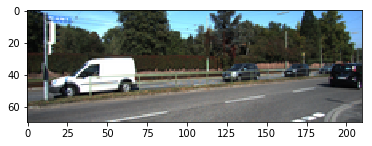

In [140]:
path = "data/training/kitti_train_img/000023_10.png"
testImg = cv.imread(path, 1)
testImg = cv.resize(testImg, (210, 70))
display(testImg)

In [141]:
# Functions to get image features
def get_mean_color(img, i, j):
    sb = 0
    sg = 0
    sr = 0
    index = 0
    for k in range(-1, 2, 1):
        for l in range(-1, 2, 1):
            if (((i+k)<img.shape[0] and (i+k)>=0) and ((j+l)<img.shape[1] and (j+l)>=0)):
                sb += img[i+k, j+l, 0]
                sg += img[i+k, j+l, 1]
                sr += img[i+k, j+l, 2]
                index += 1
    return ([(sb/index), (sg/index), (sr/index)])

def get_sd_color(img, i, j, mean_colors):
    sb = 0
    sg = 0
    sr = 0
    index = 0
    for k in range(-1, 2, 1):
        for l in range(-1, 2, 1):
            if (((i+k)<img.shape[0] and (i+k)>=0) and ((j+l)<img.shape[1] and (j+l)>=0)):
                sb += np.square(img[i+k, j+l, 0] - mean_colors[0])
                sg += np.square(img[i+k, j+l, 1] - mean_colors[1])
                sr += np.square(img[i+k, j+l, 2] - mean_colors[2])
                index += 1
    return ([np.sqrt(sb/index), np.sqrt(sg/index), np.sqrt(sr/index)])

#imgGrad is output of laplacian operator on a grayscale img
def gradStrn(imgGrad, i, j, maxGrad):
    value = (imgGrad[i, j])/(maxGrad+1e-10)
    return value

def get_norm_angle(i, j):
    angle = np.arctan(i/(j+1e-10))
    norm_angle = angle/(2*np.pi)
    return norm_angle

def get_norm_x(j, maxX):
    return (j/(maxX+1e-10))

def get_norm_y(i, maxY):
    return (i/(maxY+1e-10))


#This feature vect is of size [img.rows, img.cols, 13]
class featureVec:
    def __init__(self, img, grayImg):
        #ingnore error for unsigned int
        np.seterr(over='ignore')
        #for gradient strength part
        lapl = cv.Laplacian(grayImg,cv.CV_64F)
        maxGrad = np.abs(lapl[0,0])
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if np.abs(lapl[i, j]) > maxGrad:
                    maxGrad = np.abs(lapl[i, j])

        self.values = np.zeros((img.shape[0], img.shape[1], 13), dtype = float)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mean_colors = get_mean_color(img, i, j)
                sd_colors = get_sd_color(img, i, j, mean_colors)
                self.values[i, j, 0] = img[i, j, 0]
                self.values[i, j, 1] = img[i, j, 1]
                self.values[i, j, 2] = img[i, j, 2]
                self.values[i, j, 3] = mean_colors[0]
                self.values[i, j, 4] = mean_colors[1]
                self.values[i, j, 5] = mean_colors[2]
                self.values[i, j, 6] = sd_colors[0]
                self.values[i, j, 7] = sd_colors[1]
                self.values[i, j, 8] = sd_colors[2]
                self.values[i, j, 9] = gradStrn(lapl, i, j, maxGrad)
                self.values[i, j, 10] = get_norm_angle(i, j)
                self.values[i, j, 11] = get_norm_x(j, img.shape[1])
                self.values[i, j, 12] = get_norm_x(i, img.shape[0])

In [142]:
# Network architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [143]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [144]:
#load the pre trained pytorch model
net = torch.load("t_model_250.pt")

In [145]:
print(net)

Net(
  (fc1): Linear(in_features=13, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)


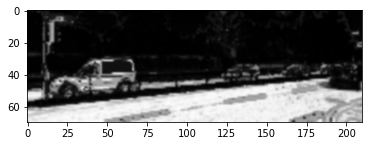

In [146]:
testImg = cv.imread(path, 1)
test_X = np.zeros((testImg.shape[0], testImg.shape[1], 13), dtype = float)
grayImg = cv.imread(path, 0)
features = featureVec(testImg, grayImg)
test_X = features.values
t_link = np.zeros((testImg.shape[0], testImg.shape[1]), dtype = float)
outImg = np.zeros((testImg.shape[0], testImg.shape[1]), dtype = int)

for i in range(test_X.shape[0]):
    w1 = torch.from_numpy(test_X[i])
    w1 = w1.to(device)
    w1 = net(w1.float())
    w1 = np.reshape(((w1.cpu()).detach()).numpy(), -1)
    t_link[i] = w1
    outImg[i] = np.rint(255*t_link[i])
display(outImg)

In [147]:
fg = (outImg > 180).astype(int)

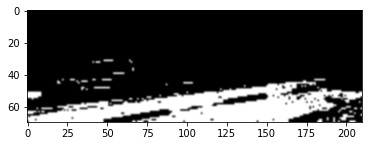

In [148]:
display(fg)

In [149]:
bg = (outImg < 3).astype(int)

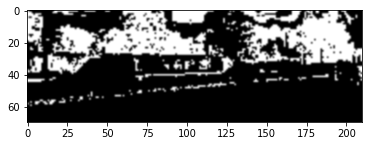

In [150]:
display(bg)

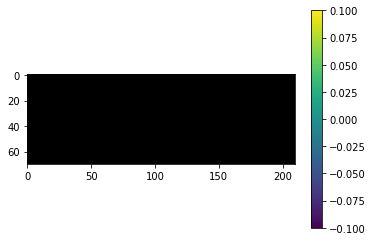

(<matplotlib.image.AxesImage at 0x7fce937d0a90>,
 None)

In [152]:
img = cv.imread(path)
#mask = np.zeros(img.shape[:2],np.uint8)
mask = np.ones(img.shape[:2],np.uint8)
mask = mask*2
mask = mask + (fg).astype(np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (0,0,img.shape[1]-1, img.shape[0]-1)
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()